In [57]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from __future__ import annotations
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
def splitData(data, splitColumn, splitValue):
    splitColumnValues = data[:, splitColumn]
    return data[splitColumnValues <= splitValue], data[splitColumnValues > splitValue]
count = 3
def calculateEntropy(data):
    _, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    return sum(probabilities * -numpy.log2(probabilities))
def calculateOverallEntropy(dataBelow, dataAbove):
    pDataBelow = len(dataBelow) / (len(dataBelow) + len(dataAbove))
    pDataAbove = len(dataAbove) / (len(dataBelow) + len(dataAbove))
    return pDataBelow * calculateEntropy(dataBelow) + pDataAbove * calculateEntropy(dataAbove)
def classifySample(sample, decisionTree):
    if not isinstance(decisionTree, dict):
        return decisionTree
    question = list(decisionTree.keys())[0]
    attribute, value = question.split(" <= ")
    if sample[attribute] <= float(value):
        answer = decisionTree[question][0]
    else:
        answer = decisionTree[question][1]
    return classifySample(sample, answer)
def decisionTreePredictions(dataFrame, decisionTree):
    predictions = dataFrame.apply(classifySample, axis = 1, args = (decisionTree,))
    return predictions
def calculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()
def buildDecisionTree(dataFrame, currentDepth = 0, minSampleSize = 2, maxDepth = 1000, randomAttributes = None, randomSplits = None):
    if currentDepth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataFrame.columns
        data = dataFrame.values
        if randomAttributes != None and randomAttributes <= len(COLUMN_HEADERS) - 1:
            randomAttributes = random.sample(population = list(range(len(COLUMN_HEADERS) - 1)), k = randomAttributes)
        else:
            randomAttributes = None
    else:
        data = dataFrame
    if checkPurity(data) or len(data) < minSampleSize or currentDepth == maxDepth:
        return classifyData(data)
    else:
        currentDepth += 1
        potentialSplits = getPotentialSplits(data, randomAttributes)
        splitColumn, splitValue = determineBestSplit(data, potentialSplits, randomSplits)
        dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
        if len(dataBelow) == 0 or len(dataAbove) == 0:
            return classifyData(data)
        else:
            question = str(COLUMN_HEADERS[splitColumn]) + " <= " + str(splitValue)
            decisionSubTree = {question: []}
            yesAnswer = buildDecisionTree(dataBelow, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            noAnswer = buildDecisionTree(dataAbove, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            if yesAnswer == noAnswer:
                decisionSubTree = yesAnswer
            else:
                decisionSubTree[question].append(yesAnswer)
                decisionSubTree[question].append(noAnswer)
            return decisionSubTree
class DecisionTree:
    def categorical_options(a):
        a = a.unique()
        opciones = []
        for L in range(0, len(a)+1):
            for subset in itertools.combinations(a, L):
                subset = list(subset)
                opciones.append(subset)
        return opciones[1:-1]
    def __init__(self, data: np.ndarray, depth: int, left: DecisionTree, right: DecisionTree, threshold: float,
                 max_depth: int):
        self.left = left
        self.right = right
        self.data = data
        self.depth = depth
        self.threshold = threshold
        self.is_leaf = False
        self.max_depth = max_depth
        self.left_rule = None  
        self.best_index = -1
    def post_prune(self, alpha):                
        left_acc = self.calc_p(self.left.data) * len(self.left.data)
        right_acc = self.right.calc_p(self.right.data) * len(self.right.data)
        imporvment = left_acc + right_acc - self.calc_p(self.data)
        if alpha <= imporvment:
            return False
        else:
            return True  
    def predict_data(self, input: np.ndarray, search_max_depth=100, current_depth=1, alpha=0.00):
        if input.ndim == 1:
            if self.is_leaf == True or self.left is None or self.right is None or self.best_index == -1 or search_max_depth <= current_depth or self.post_prune(
                    alpha):
                results = self.data[:, -1]
                b = Counter(results.tolist())
                return b.most_common(1)[0][0]
            if input[self.best_index] == self.left_rule:
                return self.left.predict_data(input, current_depth=current_depth + 1 ,alpha=alpha , search_max_depth=search_max_depth)
            else:
                return self.right.predict_data(input, current_depth=current_depth + 1,alpha=alpha , search_max_depth=search_max_depth)
        else:
            m, n = input.shape
            results = []
            for i in range(m):
                res = self.predict_data(input[i, :],alpha=alpha , search_max_depth=search_max_depth)
                results.append(res)
            results = np.array(results)
            return results
    def entropy_calculator(self, p):
        if p == 0 or p == 1:
            return 0
        return - (p * math.log2(p) + (1 - p) * math.log2(1 - p))
    def calc_p(self, data: np.ndarray) -> float:
        unique, counts = np.unique(data[:, -1], return_counts=True)
        my_dict = dict(zip(unique, counts))
        elements = list(my_dict.keys())
        if len(elements) == 1:
            return 1  
        first_element = my_dict[elements[0]]
        second_element = my_dict[elements[1]]
        p = first_element / (first_element + second_element)
        if p < 0.5:
            p = 1 - p
        return p
    def check_purity(self, data: np.ndarray, purity_threshold: float) -> bool:
        purity = self.calc_p(data)
        if purity > purity_threshold:
            return True
        else:
            return False
    def split_by_feature(self, data: np.ndarray, column_id: int) -> (
            np.ndarray, np.ndarray, object):
        m, n = data.shape
        unique, counts = np.unique(data[:, column_id], return_counts=True)
        my_dict = dict(zip(unique, counts))
        elements = list(my_dict.keys())
        left_rule = elements[0]
        left = []
        right = []
        for i in range(m):
            if data[i, column_id] == left_rule:
                left.append(data[i, :])
            else:
                right.append(data[i, :])
        left = np.array(left)
        right = np.array(right)
        return left, right, left_rule
    def find_best_column_feature(self):
        if self.check_purity(self.data, self.threshold):
            self.is_leaf = True
            return
        if self.depth >= self.max_depth:
            self.is_leaf = True
            return
        m, n = self.data.shape
        scores = []
        intial_entropy = self.entropy_calculator(self.calc_p(self.data))
        for i in range(n - 1):
            left, right, _ = self.split_by_feature(self.data, i)
            if left.ndim == 1 or right.ndim == 1:
                scores.append(0)
                continue  
            left_p = self.calc_p(left)
            left_entropy = self.entropy_calculator(p=left_p)
            right_p = self.calc_p(right)
            right_entropy = self.entropy_calculator(p=right_p)
            score = len(left) * left_entropy + len(right) * right_entropy
            score /= len(self.data)  # better to combine both 2 lines
            score = intial_entropy - score
            scores.append(score)
        self.best_index = scores.index(max(scores))
        left, right, left_rule = self.split_by_feature(self.data, self.best_index)
        if left.ndim != 1: 
            self.left_rule = left_rule
            self.left = DecisionTree(left, self.depth + 1, None, None, self.threshold, self.max_depth)
            self.left.find_best_column_feature()
        if right.ndim != 1:
            self.right = DecisionTree(right, self.depth + 1, None, None, self.threshold, self.max_depth)
            self.right.find_best_column_feature()

### Part A

In [58]:
data_set = pd.read_csv("lungcancer.csv")
main_data_set = data_set.to_numpy()
for i in range(main_data_set.shape[0]):
    if main_data_set[i,1] > 44:
        main_data_set[i,1] = 1
    else:
        main_data_set[i,1] = 0
Xdim_for_train, Xdim_for_test, ydim_for_train, ydim_for_test = train_test_split(main_data_set[:, :16], main_data_set[:, 15], test_size=0.75,
                                                                                random_state=22)
while(count>2):
    Decision_tree_data = DecisionTree(Xdim_for_train, 0, None, None, 1, 16)
    Decision_tree_data.find_best_column_feature()
    count -= 2
    _, uniqueClassesCounts = np.unique(main_data_set[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    pridiction = Decision_tree_data.predict_data(Xdim_for_test)
    value_accuracy_ = accuracy_score(pridiction, ydim_for_test)
    result = precision_score(pridiction, ydim_for_test, pos_label='NO')
    print("Result: ",'\n',value_accuracy_, "as accuracy")
    print(result, "as precision \n")
    dim__y1 = pd.Series(ydim_for_test)
    dim__y2 = pd.Series(pridiction)
    print(pd.crosstab(dim__y1, dim__y2))

Result:  
 0.8663793103448276 as accuracy
0.39285714285714285 as precision 

col_0  NO  YES
row_0         
NO     11   17
YES    14  190


### Part B

In [59]:
accuracy_list,pre_list = [],[]
for i in range(0,7):
    Xdim_for_train, Xdim_for_test, ydim_for_train, ydim_for_test = train_test_split(main_data_set[:, :16], main_data_set[:, 15], test_size=0.75,
                                                                                    random_state=22)
    Decision_tree_data = DecisionTree(Xdim_for_train, 0, None, None, 1, 16)
    Decision_tree_data.find_best_column_feature()
    _, uniqueClassesCounts = np.unique(main_data_set[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    pridiction = Decision_tree_data.predict_data(Xdim_for_test)
    value_accuracy_ = accuracy_score(pridiction, ydim_for_test)
    result = precision_score(pridiction, ydim_for_test, pos_label='NO')
    accuracy_list.append(value_accuracy_)
    pre_list.append(result)
print("Result for seven iterations: ")
print("mean for accuracy: ",np.average(accuracy_list))
print("mean for precision :", np.average(pre_list))


Result for seven iterations: 
mean for accuracy:  0.8663793103448275
mean for precision : 0.39285714285714285


### Part C

In [60]:
all_possible_sizes = [0.2,0.45,0.65,0.85]
for size in all_possible_sizes:
    Xdim_for_train, Xdim_for_test, ydim_for_train, ydim_for_test = train_test_split(main_data_set[:, :16], main_data_set[:, 15], test_size=size,
                                                                                random_state=22)
    Decision_tree_data = DecisionTree(Xdim_for_train, 0, None, None, 1, 16)
    Decision_tree_data.find_best_column_feature()
    _, uniqueClassesCounts = np.unique(main_data_set[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    pridiction = Decision_tree_data.predict_data(Xdim_for_test)
    value_accuracy_ = accuracy_score(pridiction, ydim_for_test)
    result = precision_score(pridiction, ydim_for_test, pos_label='NO')
    print("train size: ", size)
    print("Result: ",'\n',value_accuracy_, "as accuracy")
    print(result, "as precision \n")
    print("___________________________________")
    

train size:  0.2
Result:  
 0.8870967741935484 as accuracy
0.75 as precision 

___________________________________
train size:  0.45
Result:  
 0.8642857142857143 as accuracy
0.5 as precision 

___________________________________
train size:  0.65
Result:  
 0.8805970149253731 as accuracy
0.6666666666666666 as precision 

___________________________________
train size:  0.85
Result:  
 0.8669201520912547 as accuracy
0.5806451612903226 as precision 

___________________________________


### Part D

In [61]:
Xdim_for_train, Xdim_for_test, ydim_for_train, ydim_for_test = train_test_split(main_data_set[:, :16], main_data_set[:, 15], 
                                                                                test_size=0.25)
accuracy_list,precision_list,pointer = [],[],[]
for current_depth_value_ in range(0 , 16):
    Decision_tree_data = DecisionTree(Xdim_for_train, 0, None, None, 1, 16)
    pointer.append(current_depth_value_)
    _, uniqueClassesCounts = np.unique(main_data_set[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    Decision_tree_data.find_best_column_feature()
    prediction = Decision_tree_data.predict_data(Xdim_for_test ,alpha=0.1 , 
                                                 search_max_depth=current_depth_value_)
    value_for_accuracy = accuracy_score(prediction, ydim_for_test)
    value_for_precison = precision_score(prediction, ydim_for_test, pos_label='NO')
    accuracy_list.append(value_for_accuracy)
    precision_list.append(value_for_precison)

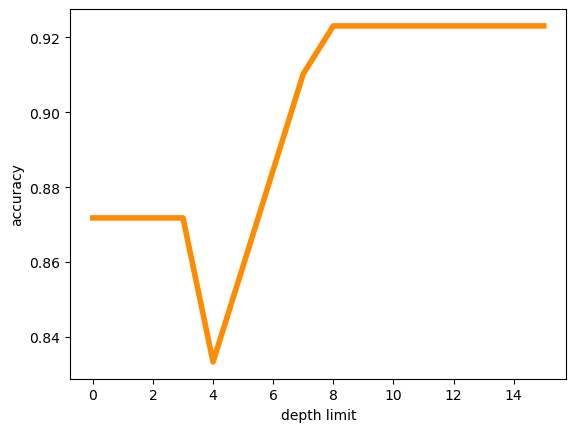

In [62]:
plt.xlabel("depth limit")
plt.ylabel("accuracy")
plt.plot(pointer,accuracy_list,color="darkorange", linewidth=4)

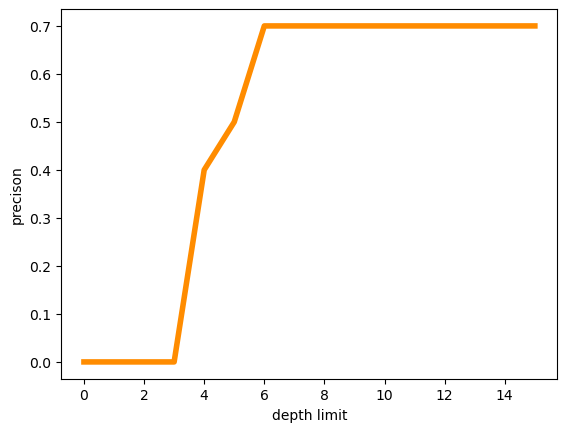

In [63]:
plt.xlabel("depth limit")
plt.ylabel("precison")
plt.plot(pointer,precision_list,color="darkorange", linewidth=4)